# 08. PyTorch Paper Replication
Ref - https://www.learnpytorch.io/08_pytorch_paper_replicating/
![vision transformer](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-applying-vit-to-food-vision-mini.png)

### What is a research paper ?
|Section|Contents|
|--|--|
|Abstract|An overview/summary of the paper's main findings/contributions.|
|Introuction|	What's the paper's main problem and details of previous methods used to try and solve it.|
|Method|How did the researchers go about conducting their research? For example, what model(s), data sources, training setups were used?|
|Results|	What are the outcomes of the paper? If a new type of model or training setup was used, how did the results of findings compare to previous works? (this is where experiment tracking comes in handy)|
|Conclusions|	What are the limitations of the suggested methods? What are some next steps for the research community?|
|References|	What resources/other papers did the researchers look at to build their own body of work?|
|Appendix|Are there any extra resources/findings to look at that weren't included in any of the above sections?|


### Where to find them?
|Resource|What is it?|
|--|--|
|[arXiv](https://arxiv.org/)|Pronounced "archive", arXiv is a free and open resource for reading technical articles on everything from physics to computer science (inlcuding machine learning).|
|[AK Twitter](https://twitter.com/_akhaliq)|The AK Twitter account publishes machine learning research highlights, often with live demos almost every day. I don't understand 9/10 posts but I find it fun to explore every so often.|
|[Papers with Code](https://paperswithcode.com/)|A curated collection of trending, active and greatest machine learning papers, many of which include code resources attached. Also includes a collection of common machine learning datasets, benchmarks and current state-of-the-art models.|
|lucidrains' `vit-pytorch` [GitHub repository](https://github.com/lucidrains/vit-pytorch)|Less of a place to find research papers and more of an example of what paper replicating with code on a larger-scale and with a specific focus looks like. The vit-pytorch repository is a collection of Vision Transformer model architectures from various research papers replicated with PyTorch code (much of the inspiration for this notebook was gathered from this repository).|

* <b>ViT</b> - Stands for Vision Transformer (the main neural network architecture we're going to be focused on replicating).
* <b>ViT Paper</b> - Short hand for the original machine learning research paper that introduced the ViT architecture, [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), anytime ViT paper is mentioned, you can be assured it is referencing this paper.

## 0. Getting Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders
### 2.1 Prepare transform

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into `DataLoader`'s

In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x21c04abb350>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

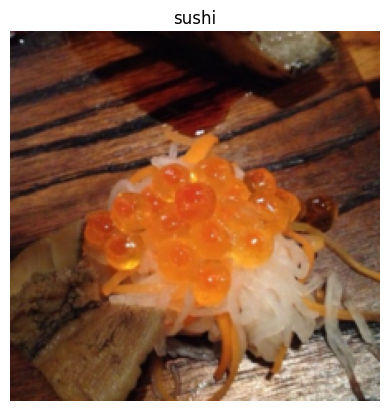

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replacing the ViT paper: an overview

### 3.1 Inputs and outputs, layers and blocks

* _Layer_ - takes an input, performs a function on it, returns an output.
* _Block_ - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* _Architecture (or model)_ - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

![architecture](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png)

### 3.2 Getting specific : What is ViT made of?
#### 3.2.1 Exploring Figure 1
![Figure 1](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png)

The ViT architecture is comprised of several stages:

* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer `torch.nn.LayerNorm()`.
* **Multi-Head Attention** - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer `torch.nn.MultiheadAttention()`.
* **MLP (or Multilayer perceptron)** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between them (section 3.1) and a `torch.nn.Dropout()` layer after each (Appendex B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

![Modified Fig 1](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png)